In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import re

In [2]:
def read_file(path):
    with open(path, 'r') as f:
        return f.read()
    
def parse_me_id(contents):
    
    # read times sequentially
    return np.array(list(map(int, re.findall(r'MeId: (.*?)>', contents))))
    
def parse_param(contents, param):
    
    # read times sequentially
    return np.array(list(map(int, re.findall(r'{}=(.*?) '.format(param), contents))))
    
def parse_field(contents, field):

    # read times sequentially
    return np.array(list(map(float, re.findall(r'{}: *(.*?) '.format(field), contents))))

def array_to_max_yet(a):
    a = a.copy()
    curr_max = a[0]
    for i in range(len(a)):
        curr_max = max(a[i], curr_max)
        a[i]     = curr_max
    return a
    
def plot_results(file_path, title=None, baseline=None):
    
    # the outputs of the script
    d = read_file(file_path)

    # read times sequentially
    y = parse_field(d, 'flops')
    t = parse_field(d, 'time')

    plt.figure(figsize=(16,9))
    
    # plot the results
    plt.plot(y, color='grey', label='all points visited')
    
    # get the current best data
    b = array_to_max_yet(y)
    plt.plot(b, label='current best')
    
    if baseline:
        plt.plot(np.ones(len(b))*baseline, label='baseline')

    if title != None:
        plt.title(f'{title} ({sum(t):.2f} sec)')
    else:
        plt.title(file_path[file_path.index('/')+1:file_path.index('.txt')])
    plt.ylim(min(min(y), baseline)-2, max(b[-1], baseline)+2)
    plt.ylabel('flops (GFlops)')
    plt.xlabel('points visited in feature space')
    plt.legend()
    plt.grid()
    plt.show()
    

In [3]:
file_path = 'data/baseline_core.txt'

# the outputs of the script
d = read_file(file_path)

# read times sequentially
baseline_pt = parse_field(d, 'flops')[0]

### Baseline Results:

```
n1=256 n2=256 n3=256 nreps=100 num_threads=16 HALF_LENGTH=8
n1_thrd_block=32 n2_thrd_block=32 n3_thrd_block=32
allocating prev, next and vel: total 192 Mbytes
-------------------------------
time:           1.89 sec
throughput:   730.38 MPoints/s
flops:         44.55 GFlops

Using command:
mpirun -np 1 -map-by ppr:1:socket -bind-to socket bin/iso3dfd_dev13_cpu_avx512.exe 256 256 256 16 100 32 32 32
```

### Plotting curves for single process runs
> Add files in the format `(<filepath>, <title>)`

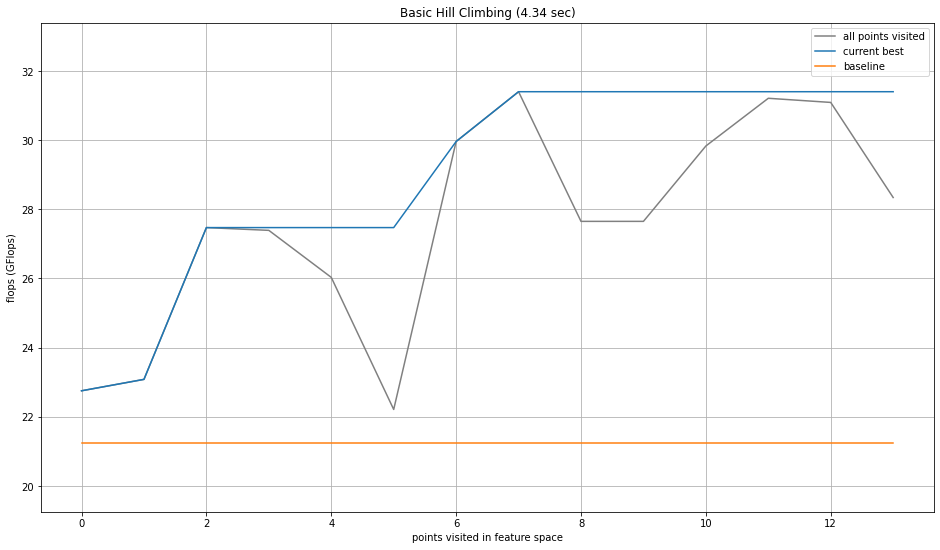

In [4]:
files = [
    ('data/SA_core.txt', 'Simulated Annealing'),
    ('data/HC_core.txt', 'Basic Hill Climbing'),
]

for file_path, title in files:
    plot_results(file_path, title, baseline=baseline_pt)

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

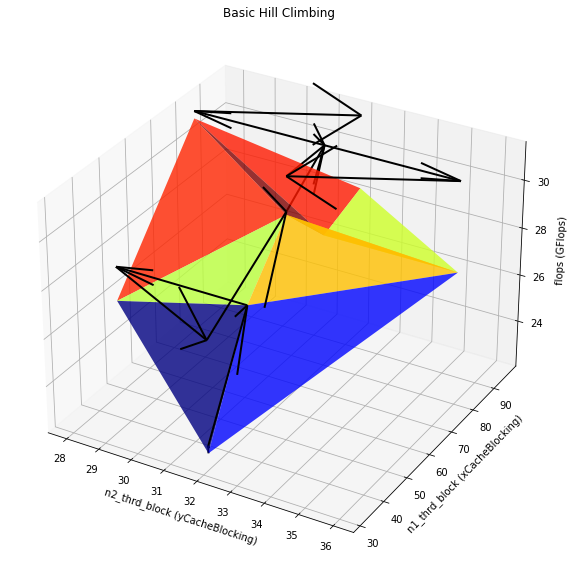

In [6]:
for j, (file_path, title) in enumerate(files):

    contents = read_file(file_path)
    flops = parse_field(contents, 'flops')
    xcb = parse_param(contents, 'n1_thrd_block')
    ycb = parse_param(contents, 'n2_thrd_block')

    fig = plt.figure(figsize=(20,10))
    
    ax = plt.axes(projection='3d')
    jet = plt.get_cmap('jet')
    ax.plot_trisurf(ycb, xcb, flops, cmap = jet, linewidth = 0, alpha=.8)

    ax.set_xlabel('n2_thrd_block (yCacheBlocking)')
    ax.set_ylabel('n1_thrd_block (xCacheBlocking)')
    ax.set_zlabel('flops (GFlops)')
    ax.set_title(title)
    
    best_flops = array_to_max_yet(flops)
    
    for i in range(min(len(best_flops)-1, 10000)): #
    
        x0, y0, z0 = xcb[i], ycb[i], best_flops[i] 
        x1, y1, z1 = xcb[i+1], ycb[i+1], best_flops[i+1] 
    
        ax.quiver(
            y0, x0, z0, # <-- starting point of vector
            y1-y0, x1-x0, z1-z0, # <-- directions of vector
            color = 'black', alpha = 1, lw = 2,
        )
        
        plt.savefig(f'gifs2/{j}/{str(i).zfill(4)}.png',transparent=False, edgecolor='white', facecolor='white')
        
    plt.show()


### create gifs from individual steps in the previous plot

In [7]:
import imageio
import os

for i in range(len(files)):

    folder = f'gifs/{i}' 
    imfiles = [f"{folder}/{file}" for file in os.listdir(folder)]
    
    imfiles = sorted(imfiles)

    images = [imageio.imread(file) for file in imfiles]
    imageio.mimwrite(f'movie{i}.gif', images, fps=10)

RuntimeError: Zero images were written.

### use all of the points found by all methods to plot the parameter / time curve

> plot the steps of individual methods on the given space

In [ ]:
for j, (file_path, title) in enumerate(files):
    
    xcbs   = []
    ycbs   = []
    flopss = []

    for file_path_, title_ in files:
        contents_ = read_file(file_path_)
        flopss.append(parse_field(contents_, 'flops'))
        xcbs.append(parse_param(contents_, 'n1_thrd_block'))
        ycbs.append(parse_param(contents_, 'n2_thrd_block'))


    xcb = np.hstack(xcbs)
    ycb = np.hstack(ycbs)
    flops = np.hstack(flopss)

    fig = plt.figure(figsize=(20,10))

    ax = plt.axes(projection='3d')
    jet = plt.get_cmap('jet')
    ax.plot_trisurf(ycb, xcb, flops, cmap = jet, linewidth = 0, alpha=.7)

    contents = read_file(file_path)
    flops = parse_field(contents, 'flops')
    xcb = parse_param(contents, 'n1_thrd_block')
    ycb = parse_param(contents, 'n2_thrd_block')

    ax.set_xlabel('n2_thrd_block (yCacheBlocking)')
    ax.set_ylabel('n1_thrd_block (xCacheBlocking)')
    ax.set_zlabel('flops (GFlops)')
    ax.set_title(title)
    
    best_flops = array_to_max_yet(flops)
    
    for i in range(min(len(best_flops)-1, 36)): #
    
        x0, y0, z0 = xcb[i], ycb[i], best_flops[i] 
        x1, y1, z1 = xcb[i+1], ycb[i+1], best_flops[i+1] 
    
        ax.quiver(
            y0, x0, z0, # <-- starting point of vector
            y1-y0, x1-x0, z1-z0, # <-- directions of vector
            color = 'black', alpha = 1, lw = 2,
        )
        
        plt.savefig(f'gifs2/{j}/{str(i).zfill(4)}.png',transparent=False, edgecolor='white', facecolor='white')
    
    plt.show()

    #ax.set_zlim(13,17)

### create gifs showing the routes taken by individual methods

In [ ]:
import imageio
import os

for i in range(len(files)):

    folder = f'gifs2/{i}' 
    imfiles = [f"{folder}/{file}" for file in os.listdir(folder)]
    
    imfiles = sorted(imfiles)

    images = [imageio.imread(file) for file in imfiles]
    imageio.mimwrite(f'movie{i}_allspace.gif', images, fps=10)

---
# lets use this for multiple processes

In the multiple process approach, we will print each result with the process id at the top. See an example below:

```
.
.
.

<MeId: 7>
n1=256 n2=256 n3=256 nreps=100 num_threads=16 HALF_LENGTH=8
n1_thrd_block=32 n2_thrd_block=32 n3_thrd_block=32
allocating prev, next and vel: total 192 Mbytes
-------------------------------
time:           1.89 sec
throughput:   730.38 MPoints/s
flops:         44.55 GFlops

<MeId: 0>
n1=256 n2=256 n3=256 nreps=100 num_threads=16 HALF_LENGTH=8
n1_thrd_block=48 n2_thrd_block=32 n3_thrd_block=32
allocating prev, next and vel: total 192 Mbytes
-------------------------------
time:           1.99 sec
throughput:   720.28 MPoints/s
flops:         42.67 GFlops
```

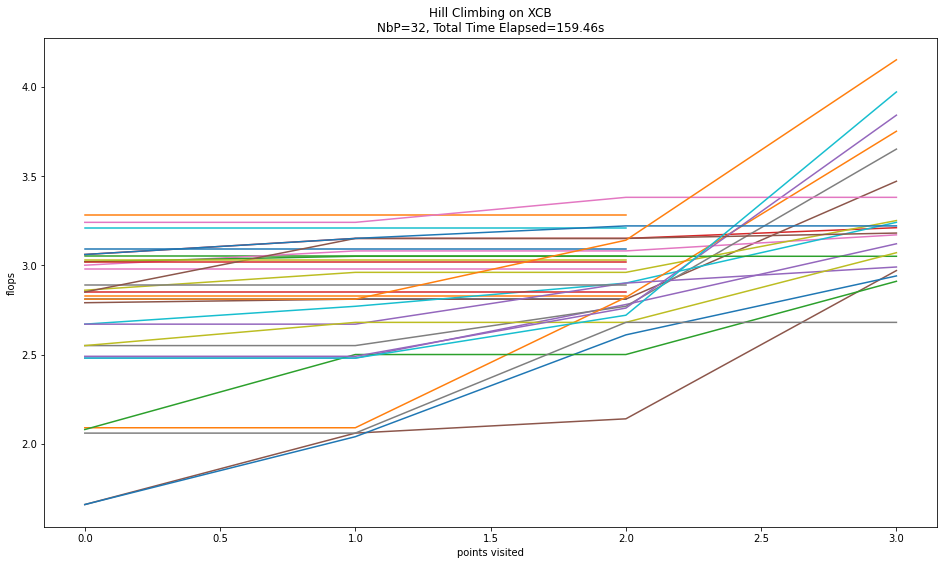

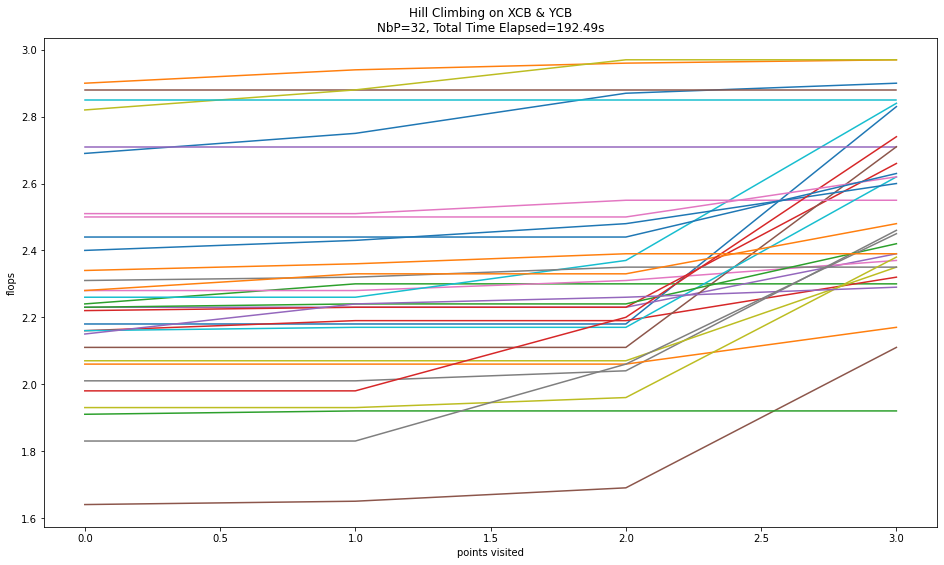

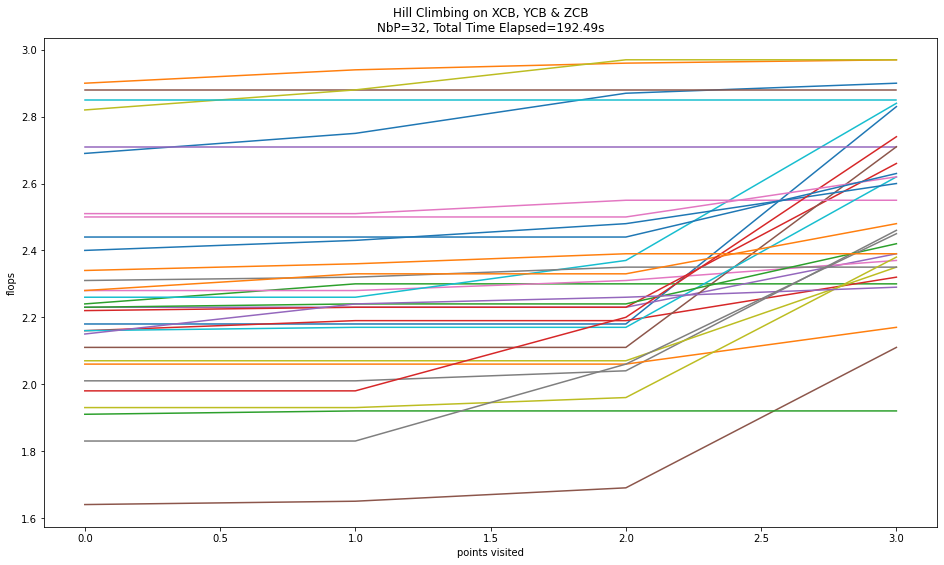

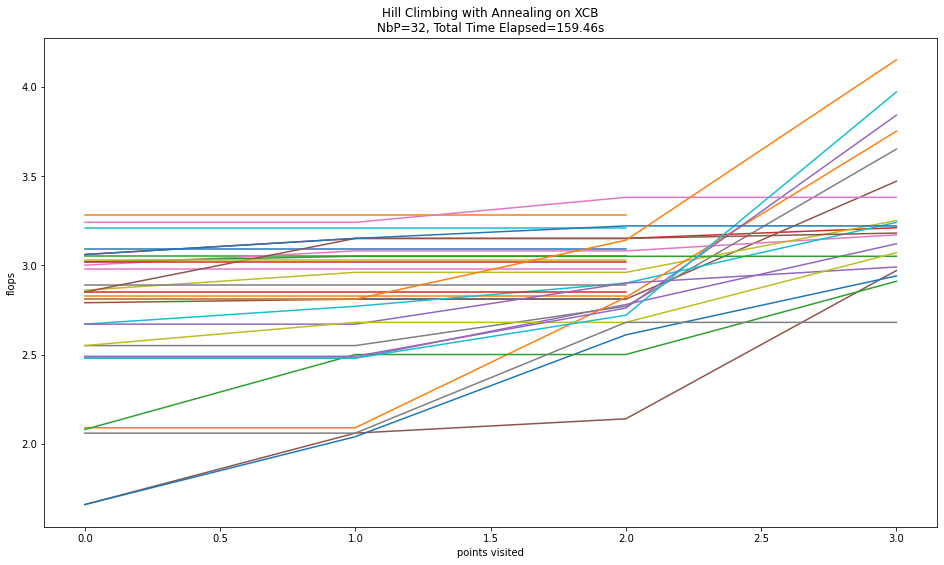

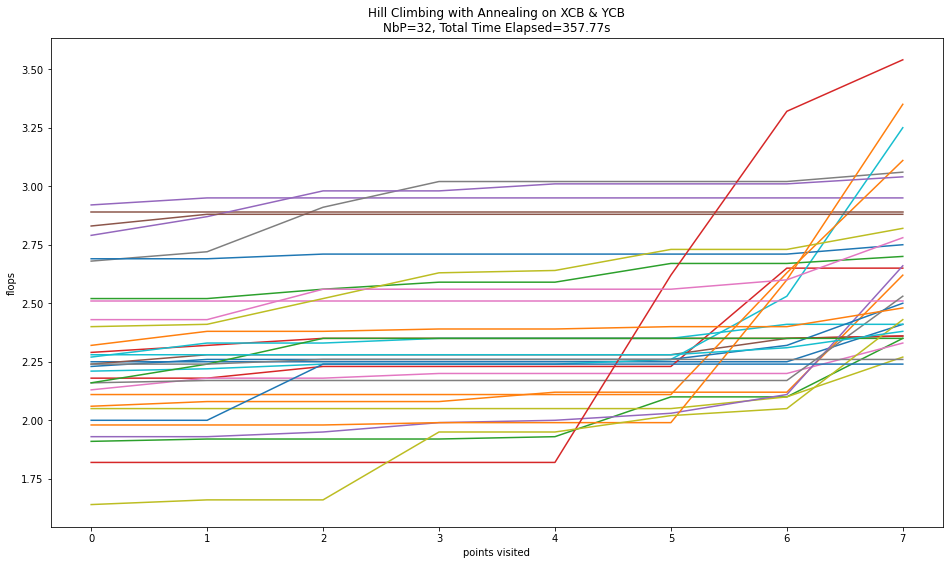

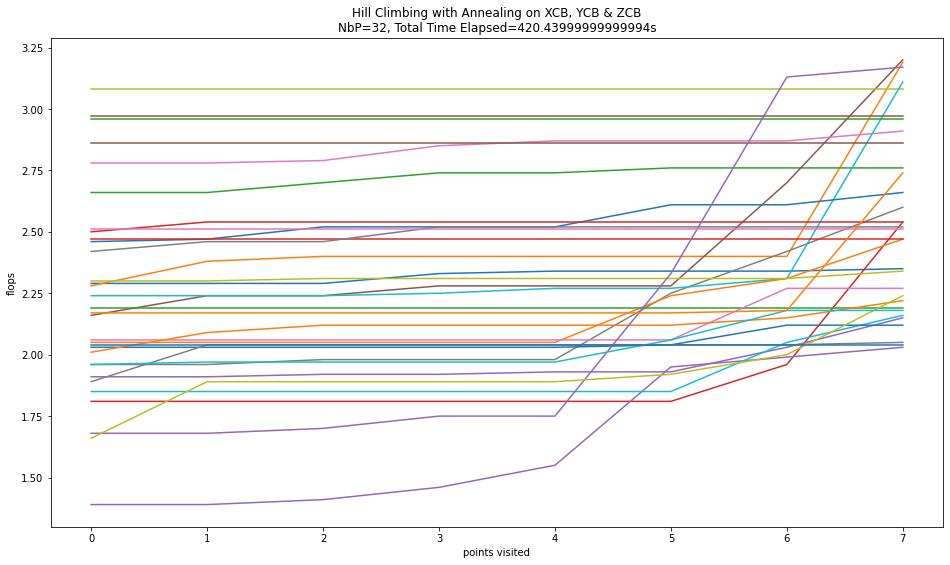

In [17]:
def plot_multiprocess_results(file_path, title, metric):
    
    parsed = read_file(file_path)

    results_per_process = {}
    times_per_process   = {}

    blocks = re.findall(r'<(.*?)GFlops', parsed, re.DOTALL)

    for block in blocks:

        me_id = parse_me_id(block)[0]
        costf = parse_field(block, metric)[0]
        timef = parse_field(block, 'time')[0]

        if me_id not in results_per_process.keys():
            results_per_process[me_id] = [costf]
            times_per_process[me_id]   = [timef]
        else:
            results_per_process[me_id].append(costf)
            times_per_process[me_id].append(timef)
            
    max_time = max(map(sum, times_per_process.values()))
    num_processes = len(results_per_process.keys())
            
    plt.figure(figsize=(16, 9))
    plt.title(f"{title}\nNbP={num_processes}, Total Time Elapsed={max_time}s")
    plt.xlabel("points visited")
    plt.ylabel(metric)
    
    for me_id, metrics in results_per_process.items():
        plt.plot(array_to_max_yet(metrics))
    plt.show()

files = [
    ('data/_MULTIPROCESS/hc_XCB.txt', 'Hill Climbing on XCB'),
    ('data/_MULTIPROCESS/hc_XCB_YCB.txt', 'Hill Climbing on XCB & YCB'),
    ('data/_MULTIPROCESS/hc_XCB_YCB_ZCB.txt', 'Hill Climbing on XCB, YCB & ZCB'),
    ('data/_MULTIPROCESS/hc_annealing_XCB.txt', 'Hill Climbing with Annealing on XCB'),
    ('data/_MULTIPROCESS/hc_annealing_XCB_YCB.txt', 'Hill Climbing with Annealing on XCB & YCB'),
    ('data/_MULTIPROCESS/hc_annealing_XCB_YCB_ZCB.txt', 'Hill Climbing with Annealing on XCB, YCB & ZCB'),
]

for file_path, title in files:
    plot_multiprocess_results(file_path, title, metric='flops')